# First Model training

## Imports

In [38]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt


DATA_PATH = 'data/grandprix_features.csv'

In [39]:
# read csv
df = pd.read_csv(DATA_PATH)
print(df.head())
print(df.dtypes)

   year  round               event driver          team  quali_position  \
0  2022      1  Bahrain Grand Prix    LEC       Ferrari               1   
1  2022      1  Bahrain Grand Prix    SAI       Ferrari               3   
2  2022      1  Bahrain Grand Prix    HAM      Mercedes               5   
3  2022      1  Bahrain Grand Prix    RUS      Mercedes               9   
4  2022      1  Bahrain Grand Prix    MAG  Haas F1 Team               7   

   avg_race_lap_time_s  finish_position  points_awarded  prev_points_total  \
0            97.604208              1.0            26.0                0.0   
1            98.079957              2.0            18.0                0.0   
2            98.266244              3.0            15.0                0.0   
3            98.639022              4.0            12.0                0.0   
4            98.852833              5.0            10.0                0.0   

   scored_points  
0              1  
1              1  
2              1  
3   

In [40]:
# Datenverteilung untersuchen
def inspect_csv(path: str):
    df = pd.read_csv(path)
    print(df.head(3))
    print("Driver value counts:")
    print(df["driver"].value_counts())

inspect_csv(DATA_PATH)

   year  round               event driver      team  quali_position  \
0  2022      1  Bahrain Grand Prix    LEC   Ferrari               1   
1  2022      1  Bahrain Grand Prix    SAI   Ferrari               3   
2  2022      1  Bahrain Grand Prix    HAM  Mercedes               5   

   avg_race_lap_time_s  finish_position  points_awarded  prev_points_total  \
0            97.604208              1.0            26.0                0.0   
1            98.079957              2.0            18.0                0.0   
2            98.266244              3.0            15.0                0.0   

   scored_points  
0              1  
1              1  
2              1  
Driver value counts:
driver
LEC    68
HAM    68
RUS    68
BOT    68
STR    68
TSU    68
ZHO    68
ALO    68
PER    68
VER    68
GAS    68
NOR    68
ALB    67
SAI    67
OCO    67
MAG    66
HUL    48
RIC    47
PIA    46
SAR    36
MSC    22
LAT    22
VET    20
DEV    11
LAW    11
COL     9
BEA     3
DOO     1
Name: count, dtype

In [41]:
# Fahrer, Teams, Events in Indizes umwandeln
drivers = sorted(df["driver"].unique())
teams = sorted(df["team"].unique())
events = sorted(df["event"].unique())

driver_to_idx = {d: i for i, d in enumerate(drivers)}
team_to_idx   = {t: i for i, t in enumerate(teams)}
event_to_idx  = {e: i for i, e in enumerate(events)}

# Umkehrung der Mappings
idx_to_driver = {idx: drv for drv, idx in driver_to_idx.items()}
idx_to_team   = {idx: tm for tm, idx in team_to_idx.items()}
idx_to_event  = {idx: ev for ev, idx in event_to_idx.items()}

print(f"Drivers: {driver_to_idx}")
print(f"Teams: {team_to_idx}")
print(f"Events: {event_to_idx}")

Drivers: {'ALB': 0, 'ALO': 1, 'BEA': 2, 'BOT': 3, 'COL': 4, 'DEV': 5, 'DOO': 6, 'GAS': 7, 'HAM': 8, 'HUL': 9, 'LAT': 10, 'LAW': 11, 'LEC': 12, 'MAG': 13, 'MSC': 14, 'NOR': 15, 'OCO': 16, 'PER': 17, 'PIA': 18, 'RIC': 19, 'RUS': 20, 'SAI': 21, 'SAR': 22, 'STR': 23, 'TSU': 24, 'VER': 25, 'VET': 26, 'ZHO': 27}
Teams: {'Alfa Romeo': 0, 'AlphaTauri': 1, 'Alpine': 2, 'Aston Martin': 3, 'Ferrari': 4, 'Haas F1 Team': 5, 'Kick Sauber': 6, 'McLaren': 7, 'Mercedes': 8, 'RB': 9, 'Red Bull Racing': 10, 'Williams': 11}
Events: {'Abu Dhabi Grand Prix': 0, 'Australian Grand Prix': 1, 'Austrian Grand Prix': 2, 'Azerbaijan Grand Prix': 3, 'Bahrain Grand Prix': 4, 'Belgian Grand Prix': 5, 'British Grand Prix': 6, 'Canadian Grand Prix': 7, 'Chinese Grand Prix': 8, 'Dutch Grand Prix': 9, 'Emilia Romagna Grand Prix': 10, 'French Grand Prix': 11, 'Hungarian Grand Prix': 12, 'Italian Grand Prix': 13, 'Japanese Grand Prix': 14, 'Las Vegas Grand Prix': 15, 'Mexico City Grand Prix': 16, 'Miami Grand Prix': 17, 'M

## Dataset Klasse

In [42]:
class GrandPrixDataset(Dataset):
    def __init__(self, csv_path: str):
        df = pd.read_csv(csv_path)

        self.drivers = sorted(df["driver"].unique())
        self.teams = sorted(df["team"].unique())
        self.events = sorted(df["event"].unique())

        self.driver_to_idx = {d: i for i, d in enumerate(self.drivers)}
        self.team_to_idx   = {t: i for i, t in enumerate(self.teams)}
        self.event_to_idx  = {e: i for i, e in enumerate(self.events)}

        # convert to tensors
        self.years = torch.tensor(df["year"].values, dtype=torch.int64)
        self.rounds = torch.tensor(df["round"].values, dtype=torch.int64)
        self.quali_positions = torch.tensor(df["quali_position"].values, dtype=torch.int64)
        self.avg_lap_times = torch.tensor(df["avg_race_lap_time_s"].values, dtype=torch.float32)
        self.prev_points = torch.tensor(df["prev_points_total"].values, dtype=torch.float32)

        driver_ids = df["driver"].map(self.driver_to_idx).values
        team_ids = df["team"].map(self.team_to_idx).values
        event_ids = df["event"].map(self.event_to_idx).values

        self.driver_ids = torch.tensor(driver_ids, dtype=torch.int64)
        self.team_ids = torch.tensor(team_ids, dtype=torch.int64)
        self.event_ids = torch.tensor(event_ids, dtype=torch.int64)

        self.targets = torch.tensor(df["scored_points"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        numeric_features = torch.tensor([
            self.years[idx],
            self.rounds[idx],
            self.quali_positions[idx],
        ], dtype=torch.float32)     

        categorical_features = torch.tensor([
            self.driver_ids[idx],
            self.team_ids[idx],
            self.event_ids[idx],
        ], dtype=torch.int64)

        x = {
            "numeric": numeric_features,
            "categorical": categorical_features,
        }

        y = self.targets[idx]
        return x, y

## Train, val, test split

In [43]:
dataset = GrandPrixDataset(DATA_PATH)

generator = torch.Generator().manual_seed(42)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_ds, val_ds, test_ds = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size],
    generator=generator
)

print(len(train_ds), len(val_ds), len(test_ds))

815 271 273


In [44]:
# DataLoader erstellen
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)


In [45]:
# Batch anschauen
x_batch, y_batch = next(iter(train_loader))

print("numeric shape:", x_batch["numeric"].shape)
print("categorical shape:", x_batch["categorical"].shape)
print("targets shape:", y_batch.shape)

print("numeric example:", x_batch["numeric"][0])
print("categorical example:", x_batch["categorical"][0])
print("target example:", y_batch[0])

numeric shape: torch.Size([32, 3])
categorical shape: torch.Size([32, 3])
targets shape: torch.Size([32])
numeric example: tensor([2.0240e+03, 2.0000e+00, 7.0000e+00])
categorical example: tensor([20,  8, 20])
target example: tensor(1.)


## Model

### Model Klasse

In [46]:
NUM_NUMERIC_FEATURES = 3

NUM_CATEGORICAL_FEATURES = 3

class SimplePointsMLP(nn.Module):
    def __init__(self, num_numeric_features):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_numeric_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        numeric = x["numeric"].float()
        return self.net(numeric)

### Modell & Loss & Optimizer

In [47]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Modell
model = SimplePointsMLP(NUM_NUMERIC_FEATURES).to(device)

# Loss und Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda


### Trainingsloop

#### Train und evaluate in Funktionen ausgelagert

In [48]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x_batch, y_batch in dataloader:
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)

        y_batch = y_batch.unsqueeze(1)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_samples += y_batch.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = {k: v.to(device) for k, v in x_batch.items()}
            y_batch = y_batch.to(device)

            y_batch = y_batch.unsqueeze(1)

            logits = model(x_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_samples += y_batch.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

#### Trainingsloop

In [49]:
num_epochs = 20
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.3f}"
    )


Epoch 01 | Train Loss: 0.9110  Acc: 0.492 | Val Loss: 0.7913  Acc: 0.531
Epoch 02 | Train Loss: 0.7526  Acc: 0.410 | Val Loss: 0.7396  Acc: 0.336
Epoch 03 | Train Loss: 0.7314  Acc: 0.448 | Val Loss: 0.7206  Acc: 0.435
Epoch 02 | Train Loss: 0.7526  Acc: 0.410 | Val Loss: 0.7396  Acc: 0.336
Epoch 03 | Train Loss: 0.7314  Acc: 0.448 | Val Loss: 0.7206  Acc: 0.435
Epoch 04 | Train Loss: 0.7288  Acc: 0.464 | Val Loss: 0.7238  Acc: 0.406
Epoch 04 | Train Loss: 0.7288  Acc: 0.464 | Val Loss: 0.7238  Acc: 0.406
Epoch 05 | Train Loss: 0.7514  Acc: 0.470 | Val Loss: 0.7064  Acc: 0.443
Epoch 06 | Train Loss: 0.7204  Acc: 0.493 | Val Loss: 0.7222  Acc: 0.469
Epoch 05 | Train Loss: 0.7514  Acc: 0.470 | Val Loss: 0.7064  Acc: 0.443
Epoch 06 | Train Loss: 0.7204  Acc: 0.493 | Val Loss: 0.7222  Acc: 0.469
Epoch 07 | Train Loss: 0.7151  Acc: 0.483 | Val Loss: 0.7873  Acc: 0.531
Epoch 08 | Train Loss: 0.7355  Acc: 0.515 | Val Loss: 0.8553  Acc: 0.469
Epoch 07 | Train Loss: 0.7151  Acc: 0.483 | Val Los

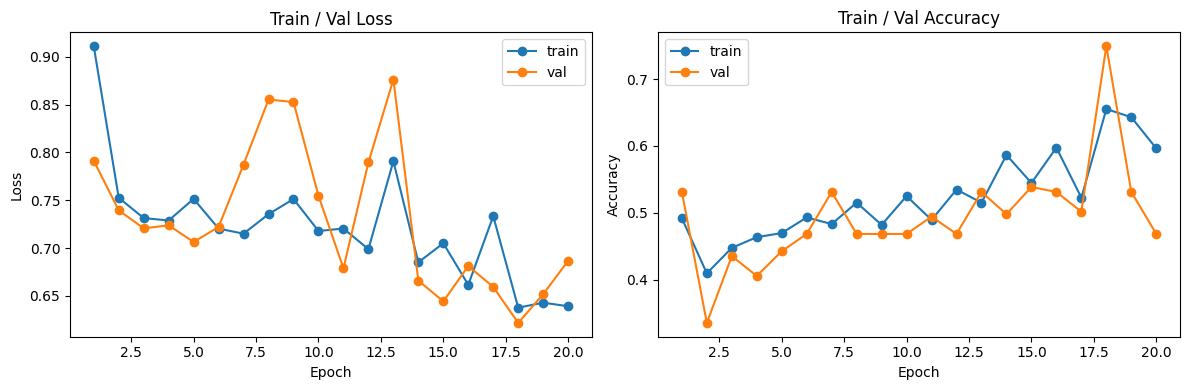

In [50]:


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_hist, marker='o', label='train')
plt.plot(range(1, num_epochs + 1), val_loss_hist, marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_hist, marker='o', label='train')
plt.plot(range(1, num_epochs + 1), val_acc_hist, marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train / Val Accuracy')
plt.legend()

plt.tight_layout()
plt.show()